<a href="https://colab.research.google.com/github/345ishaan/ControlNet-Video/blob/main/ControlNet_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.8 MB/s eta 0:00:00


In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.6 MB/s eta 0:00:00


In [3]:
import requests
import urllib.request
import cv2
import numpy as np
from PIL import Image

In [4]:
#@title Download Video Data
messi_celeb_masked_path = 'https://github.com/345ishaan/ControlNet-Video/blob/main/messi_celeb_masked.mp4?raw=true'
messi_celeb_path = 'https://github.com/345ishaan/ControlNet-Video/blob/main/messi_celeb.mp4?raw=true'
urllib.request.urlretrieve(messi_celeb_masked_path, 'messi_celeb_masked.mp4')
urllib.request.urlretrieve(messi_celeb_path, 'messi_celeb.mp4')

('messi_celeb.mp4', <http.client.HTTPMessage at 0x7f82087a8340>)

In [5]:
!ls -lsrt

total 3996
   4 drwxr-xr-x 1 root root    4096 Apr 19 13:37 sample_data
 700 -rw-r--r-- 1 root root  714000 Apr 24 07:46 messi_celeb_masked.mp4
3292 -rw-r--r-- 1 root root 3369564 Apr 24 07:46 messi_celeb.mp4


In [6]:
class FrameExtractor:

  def __init__(self, video_path):
    self.video = cv2.VideoCapture(video_path)
    self.video_fps = self.video.get(cv2.CAP_PROP_FPS)
    self.video_length = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
    self._frames = []
  
  @property
  def fps(self):
    return self.video_fps
  
  @property
  def len(self):
    return self.video_length
  
  def clear(self):
    self._frames = []
  
  def extract(self, dims, fps=None):
    if fps:
      use_fps = min(fps, self.fps)
      stride = self.fps / use_fps
    else:
      stride = None
    self.clear()
    # first frame
    succ, img = self.video.read()
    frame_cnt = 0
    while succ:
      img = cv2.resize(img, dims)
      self._frames.append(img)
      if stride:
        frame_cnt += stride
        self.video.set(1, frame_cnt)
      else:
        frame_cnt += 1
      succ,img = self.video.read()
    print(f'Extracted {len(self._frames)} frames.')

  def __iter__(self):
        self._frame_id = 0
        return self

  def __next__(self):
    if self._frame_id < len(self._frames):
        self._frame_id += 1
        return self._frames[self._frame_id -1]
    else:
        raise StopIteration

In [25]:
frame_extractor = FrameExtractor('messi_celeb_masked.mp4')

In [26]:
frame_extractor.extract(dims=[512,512])

Extracted 85 frames.


In [27]:
img = next(iter(frame_extractor))

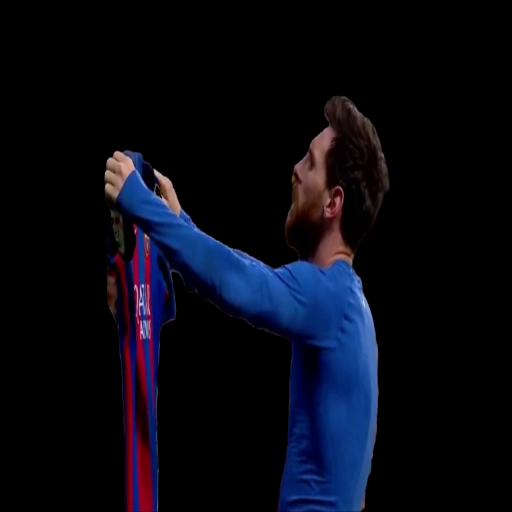

In [28]:
Image.fromarray(img[:,:,::-1])

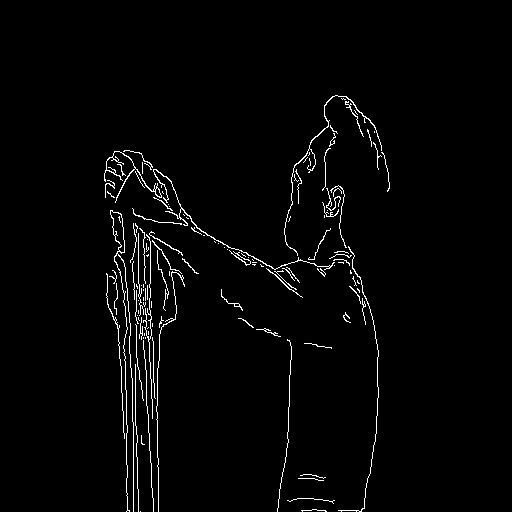

In [35]:
def _make_canny(ip_img):
  low_threshold = 100
  high_threshold = 200
  canny_image = cv2.Canny(ip_img, low_threshold, high_threshold)
  canny_image = canny_image[:, :, None]
  canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
  return Image.fromarray(canny_image)
canny_image = _make_canny(img)
canny_image

In [46]:
#@title Grid Images into a 4x4 grid (256 x 256)
img_1 = cv2.resize(frame_extractor._frames[85//4], [256,256])
img_2 = cv2.resize(frame_extractor._frames[85//2], [256,256])
img_3 = cv2.resize(frame_extractor._frames[(85*3)//4], [256,256])
img_4 = cv2.resize(frame_extractor._frames[85-1], [256,256])

In [47]:
grid_img = np.concatenate([np.concatenate([img_1, img_2], axis=1), np.concatenate([img_3, img_4], axis=1)], axis=0)
grid_canny_image = _make_canny(grid_img)

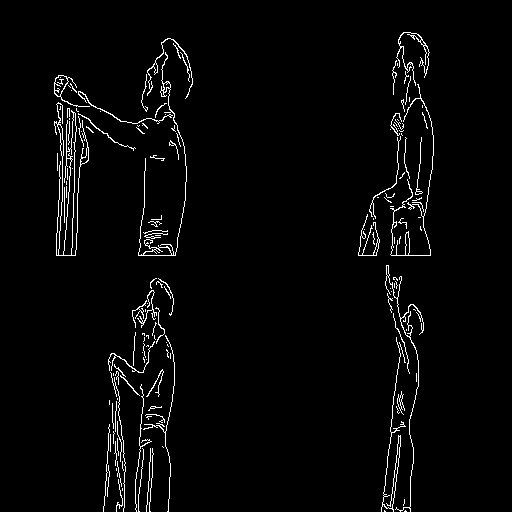

In [50]:
grid_canny_image

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [13]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/20 [00:00<?, ?it/s]

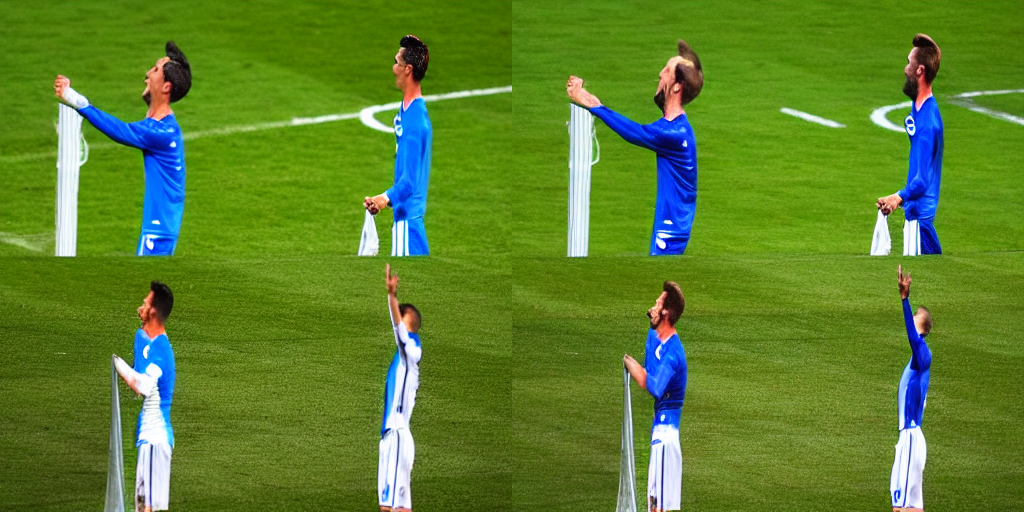

In [49]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = " in front of crowd, best quality, extremely detailed"
prompt = [t + prompt for t in ["Cristiano Ronaldo celebrating his goal", 
                               "David Beckham celebrating his goal",]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    grid_canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 1, 2)